**Laporan Proyek Machine Learning - Lilis Indra Purnama Sari**

**Sistem Prediksi Hasil Panen untuk Mendukung Perencanaan Pertanian yang Lebih Akurat**

# Library

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

Interpretasi :

Pada tahap ini saya memanggil library yang akan digunakan

# Membaca Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/DBS Camp/Predictive Analytics/crop_yield.csv')
df.head()

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251


Interpretasi :

Pada tahap ini saya membaca data yang sudah saya upload di dalam google drive saya

# Exploratory Data Analysis (EDA)

In [4]:
# Memeriksa struktur data
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Region                  1000000 non-null  object 
 1   Soil_Type               1000000 non-null  object 
 2   Crop                    1000000 non-null  object 
 3   Rainfall_mm             1000000 non-null  float64
 4   Temperature_Celsius     1000000 non-null  float64
 5   Fertilizer_Used         1000000 non-null  bool   
 6   Irrigation_Used         1000000 non-null  bool   
 7   Weather_Condition       1000000 non-null  object 
 8   Days_to_Harvest         1000000 non-null  int64  
 9   Yield_tons_per_hectare  1000000 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 62.9+ MB


,Rainfall_mm,Temperature_Celsius,Days_to_Harvest,Yield_tons_per_hectare
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,549.981901,27.504965,104.495025,4.649472
std,259.851320,7.220608,25.953412,1.696572
min,100.000896,15.000034,60.000000,-1.147613
25%,324.891090,21.254502,82.000000,3.417637
50%,550.124061,27.507365,104.000000,4.651808
75%,774.738520,33.753267,127.000000,5.879200
max,999.998098,39.999997,149.000000,9.963372


Interpretasi:

Data frame ini memiliki 1000000 baris dengan 10 kolom dengan 6 kolom kategorik dan 4 kolom numerik.

Berdasarkan hasil ringkasan statistik, keempat variabel menunjukkan variasi yang cukup besar. Curah hujan memiliki rata-rata sekitar 550 mm dengan sebaran luas, mencerminkan keberagaman kondisi wilayah. Suhu berkisar antara 15°C hingga 40°C dengan rata-rata 27,5°C, menggambarkan iklim tropis yang bervariasi. Hari menuju panen rata-rata 104 hari, menunjukkan adanya perbedaan jenis tanaman atau metode budidaya. Hasil panen per hektar memiliki rata-rata 4,65 ton, namun ditemukan nilai minimum negatif (-1,14) yang tidak logis dan kemungkinan merupakan error data. Sebagian besar hasil panen berada dalam rentang 3,4 hingga 5,9 ton per hektar. Temuan ini menunjukkan perlunya pembersihan data sebelum dilakukan analisis lebih lanjut.

In [5]:
# Cek missing value
df.isnull().sum()

,0
Region,0
Soil_Type,0
Crop,0
Rainfall_mm,0
Temperature_Celsius,0
Fertilizer_Used,0
Irrigation_Used,0
Weather_Condition,0
Days_to_Harvest,0
Yield_tons_per_hectare,0


Interpretasi:

Tidak ada missing value

In [6]:
# Cek data duplikat
df.duplicated().sum()

np.int64(0)

Interpretasi:

Tidak ada data duplikat

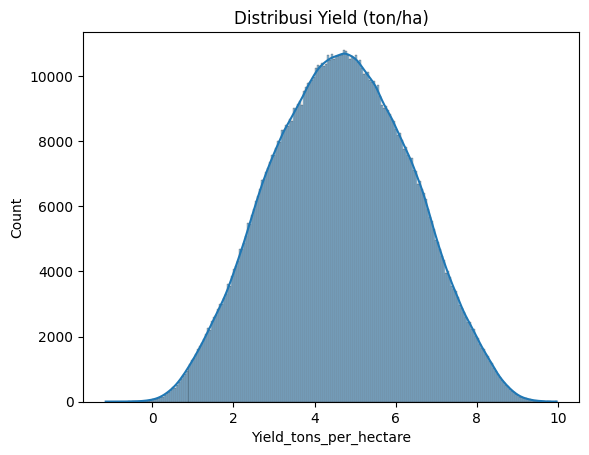

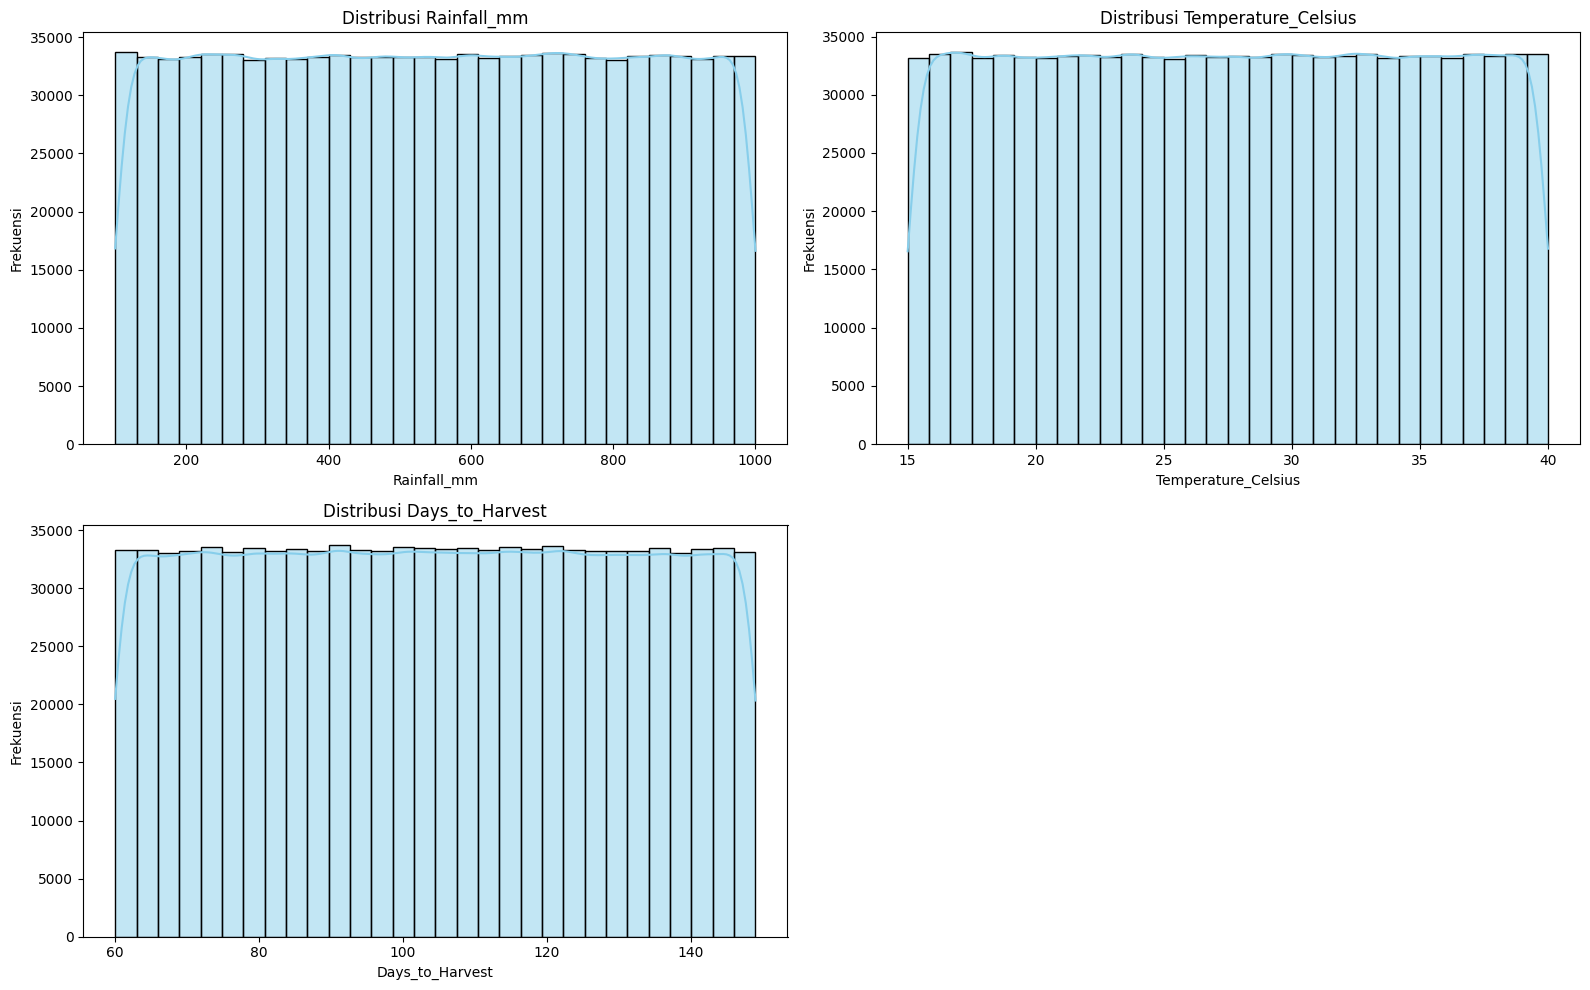

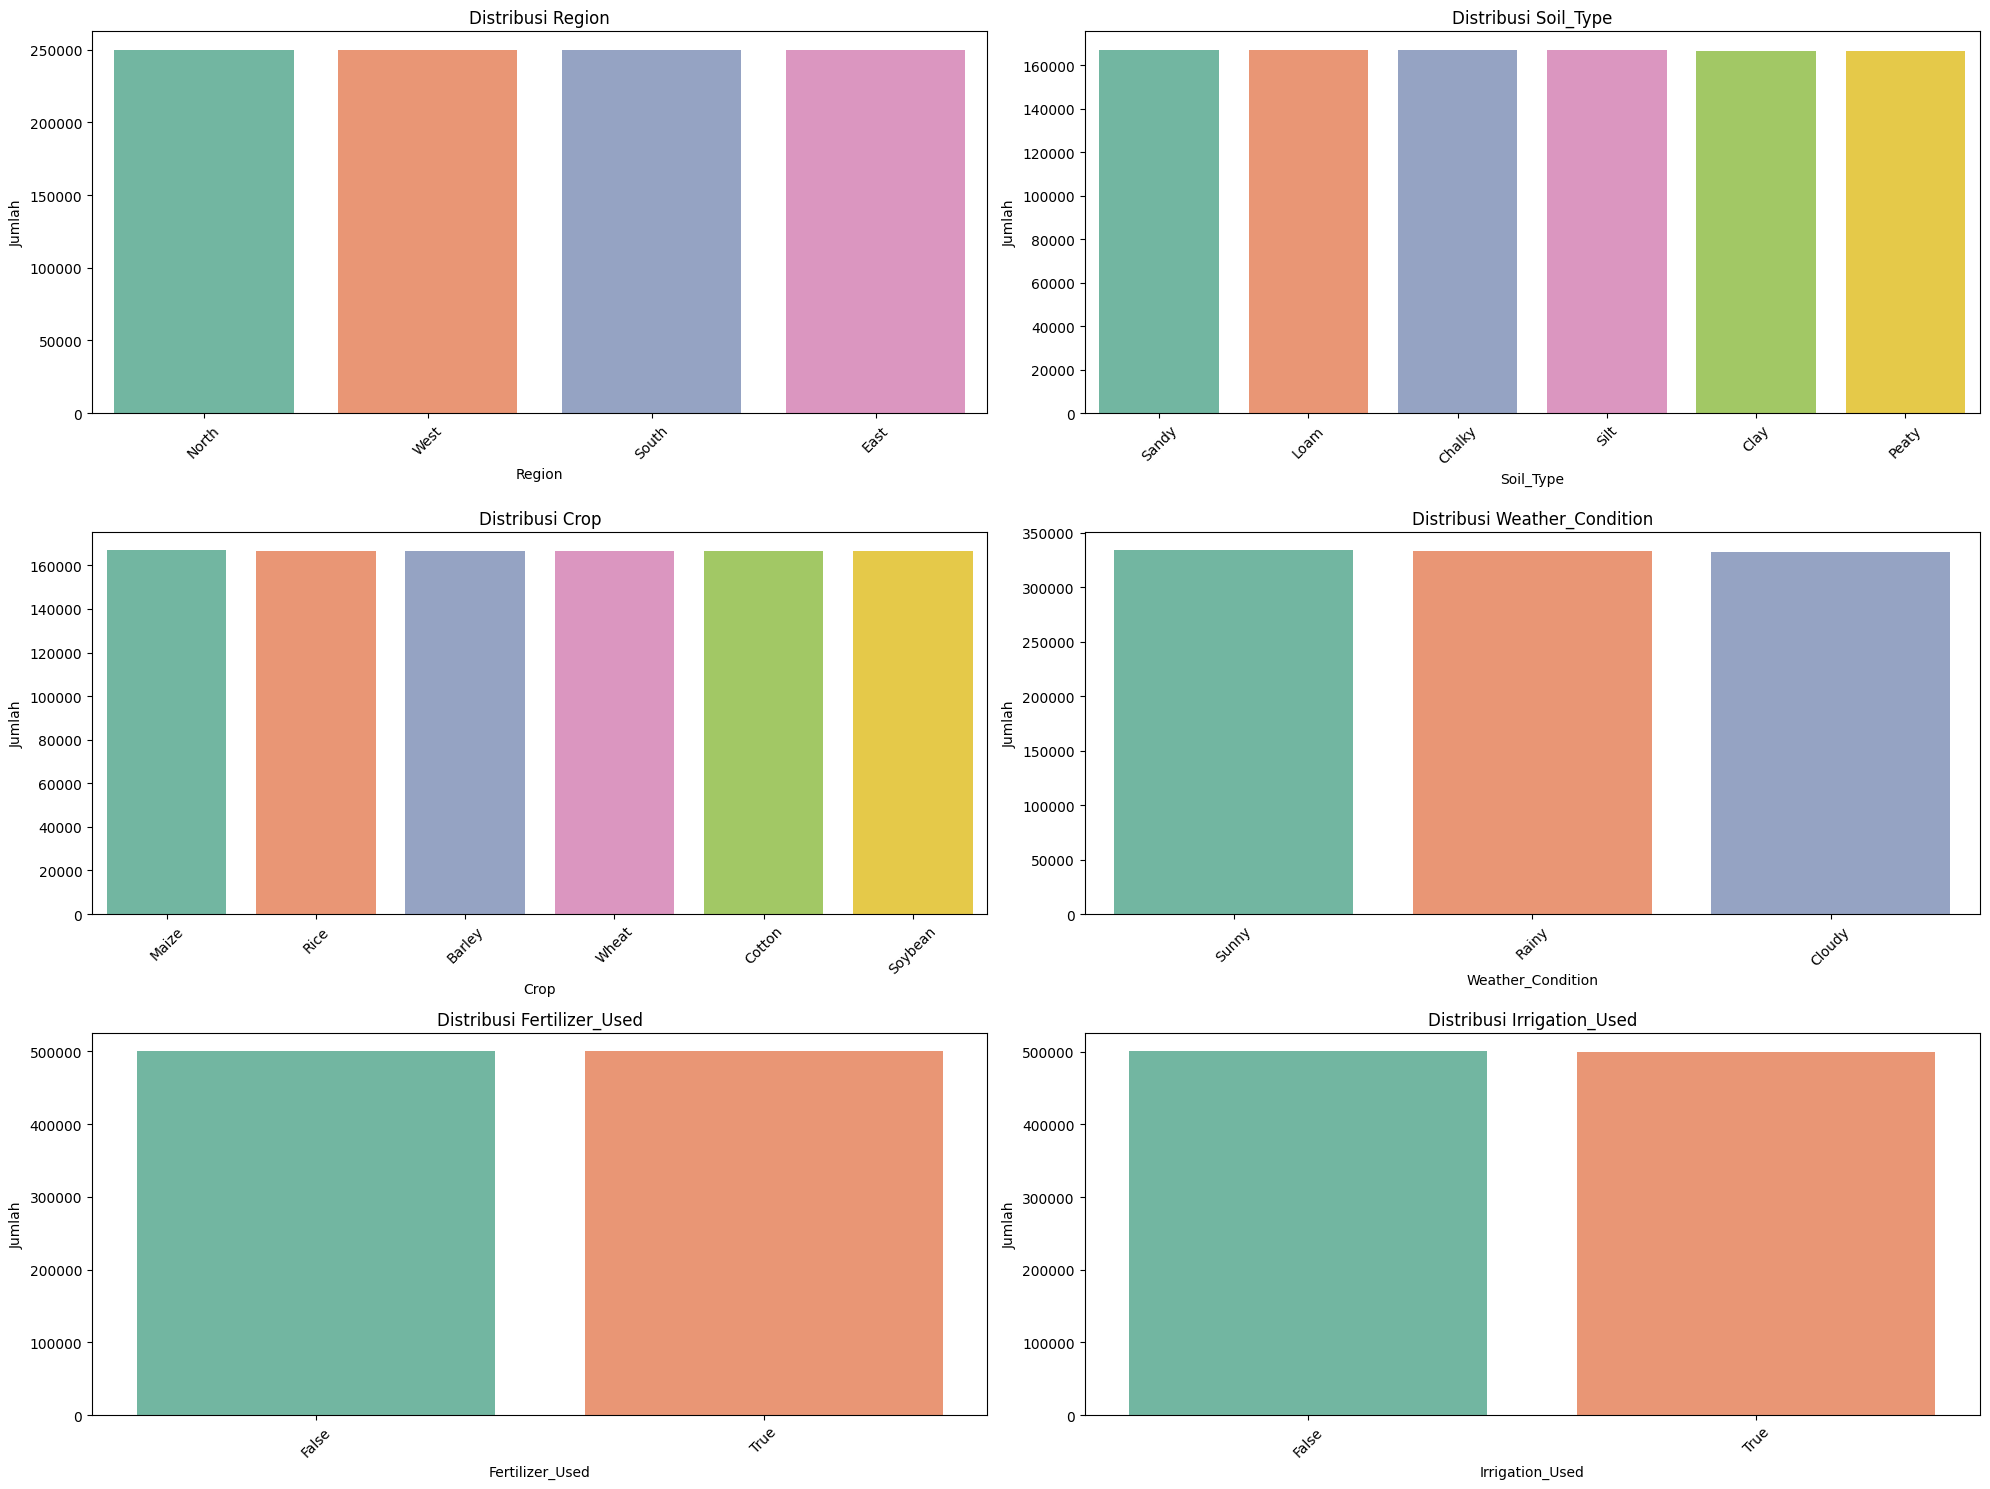

In [7]:
# Distribusi Target
sns.histplot(df['Yield_tons_per_hectare'], kde=True)
plt.title("Distribusi Yield (ton/ha)")
plt.show()

# Distribusi fitur numerik
num_features = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']

plt.figure(figsize=(16, 10))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[feature], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribusi {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()

# Distribusi fitur kategorik
cat_features = ['Region', 'Soil_Type', 'Crop', 'Weather_Condition',
                'Fertilizer_Used', 'Irrigation_Used']

# Konversi boolean ke string agar tampil jelas di visualisasi
df['Fertilizer_Used'] = df['Fertilizer_Used'].astype(str)
df['Irrigation_Used'] = df['Irrigation_Used'].astype(str)

plt.figure(figsize=(20, 15))
for i, feature in enumerate(cat_features, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=df, x=feature, order=df[feature].value_counts().index, palette='Set2')
    plt.title(f'Distribusi {feature}')
    plt.xticks(rotation=45)
    plt.xlabel(feature)
    plt.ylabel('Jumlah')

plt.tight_layout()
plt.show()

Interpretasi:

Dataset ini sangat terkontrol dan seimbang secara statistik:
- Target (yield) terdistribusi normal.
- Fitur numerik memiliki distribusi seragam.
- Fitur kategorikal merata.

Cocok untuk digunakan dalam berbagai jenis model machine learning tanpa risiko tinggi dari imbalance atau skewness.

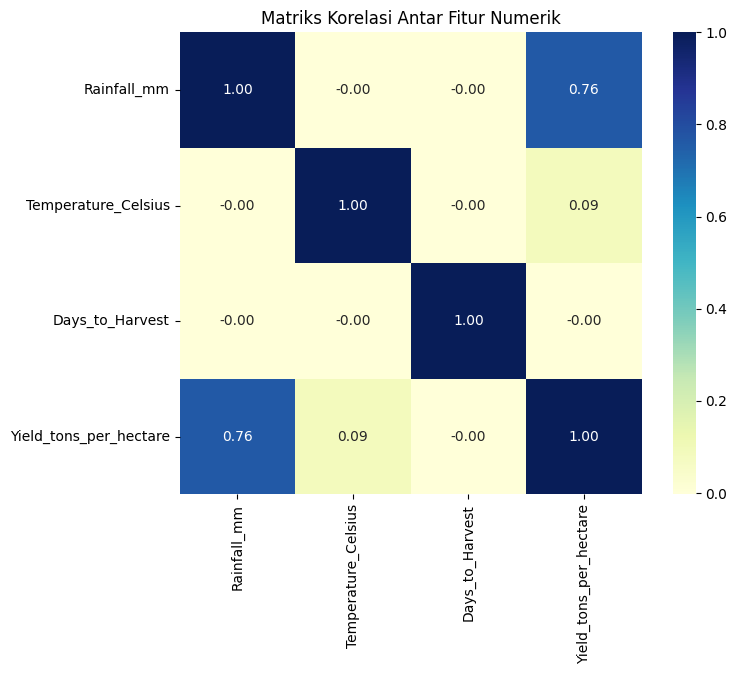

In [8]:
# Analisis korelasi antar peubah numerik

numeric_cols = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest', 'Yield_tons_per_hectare']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt=".2f", square=True)
plt.title('Matriks Korelasi Antar Fitur Numerik')
plt.show()

Interpretasi:

Rainfall_mm dan Yield_tons_per_hectare (r = 0.76)
Terdapat korelasi positif yang cukup kuat antara curah hujan dan hasil panen. Ini menunjukkan bahwa semakin tinggi curah hujan, cenderung semakin tinggi hasil panen per hektar. Fitur ini berpotensi menjadi prediktor yang penting dalam model.

Temperature_Celsius dan Yield_tons_per_hectare (r = 0.09)
Hubungan antara suhu dan hasil panen sangat lemah. Dengan korelasi mendekati nol, suhu tidak menunjukkan pengaruh linear yang signifikan terhadap hasil panen.

Days_to_Harvest dan Yield_tons_per_hectare (r = 0.00)
Tidak terdapat hubungan linier antara jumlah hari menuju panen dan hasil panen per hektar. Ini mengindikasikan bahwa variabel ini kemungkinan tidak berkontribusi besar dalam model regresi linear terhadap yield.

Antar fitur input (Rainfall, Temperature, Days_to_Harvest)
Tidak ditemukan korelasi yang signifikan antar ketiga fitur input tersebut, yang mengindikasikan tidak adanya masalah multikolinearitas.

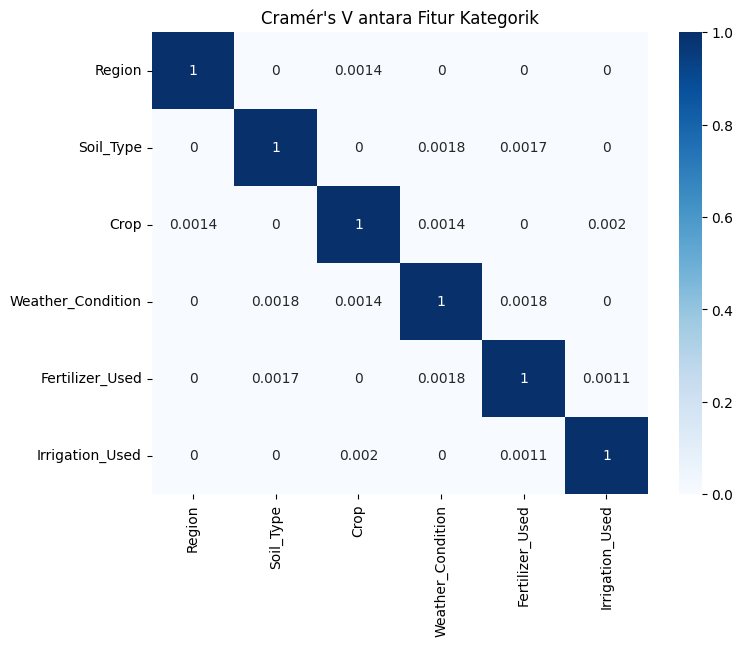

In [9]:
# Analisis korelasi antar fitur kategorik
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Definisikan fungsi cramers_v
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# 2. Daftar kolom kategorik
categorical_cols = ['Region', 'Soil_Type', 'Crop', 'Weather_Condition', 'Fertilizer_Used', 'Irrigation_Used']

# 3. Hitung Cramér's V untuk semua pasangan fitur
cramers_results = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 == col2:
            cramers_results.loc[col1, col2] = 1.0
        else:
            cramers_results.loc[col1, col2] = cramers_v(df[col1], df[col2])

cramers_results = cramers_results.astype(float)

# 4. Visualisasi heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cramers_results, annot=True, cmap='Blues')
plt.title("Cramér's V antara Fitur Kategorik")
plt.show()


Interpretasi:

Nilai Cramér’s V seluruh pasangan fitur berada di bawah 0.01, yang menunjukkan bahwa tidak ada hubungan kuat antar fitur kategorik dalam dataset ini. Hubungan antara dua variabel dikatakan lemah jika nilai Cramér’s V mendekati 0.

Beberapa contoh hubungan lemah yang ditunjukkan:

- Crop vs Irrigation_Used (0.002)
- Soil_Type vs Weather_Condition (0.0018)
- Fertilizer_Used vs Weather_Condition (0.0018)

Multikolinearitas antar fitur kategorik dapat diabaikan
Karena tidak ada nilai yang mendekati 1 (kecuali diagonal), maka fitur-fitur ini tidak saling tergantung satu sama lain secara signifikan. Artinya, semua fitur dapat digunakan secara bersamaan dalam model klasifikasi tanpa risiko redundansi informasi.

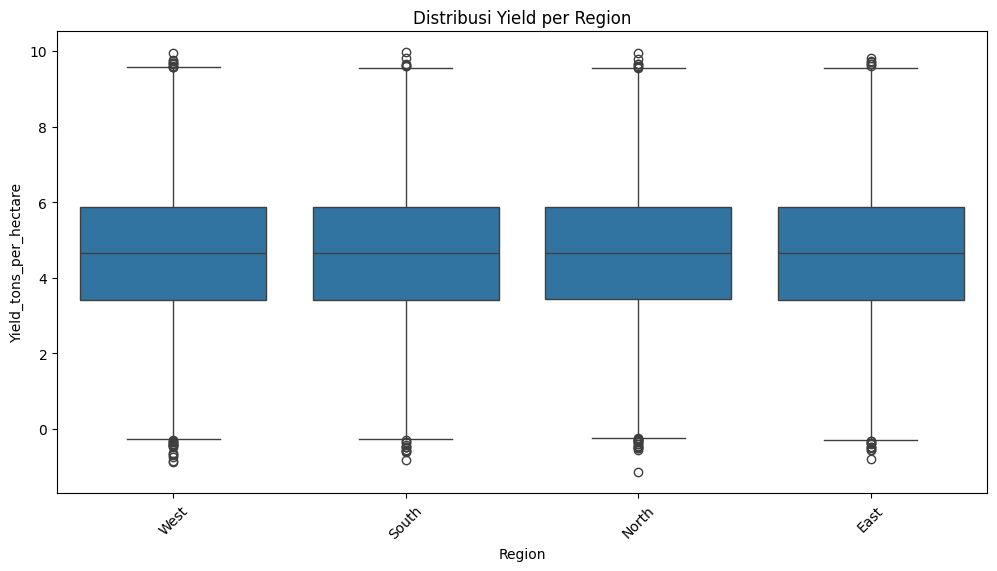

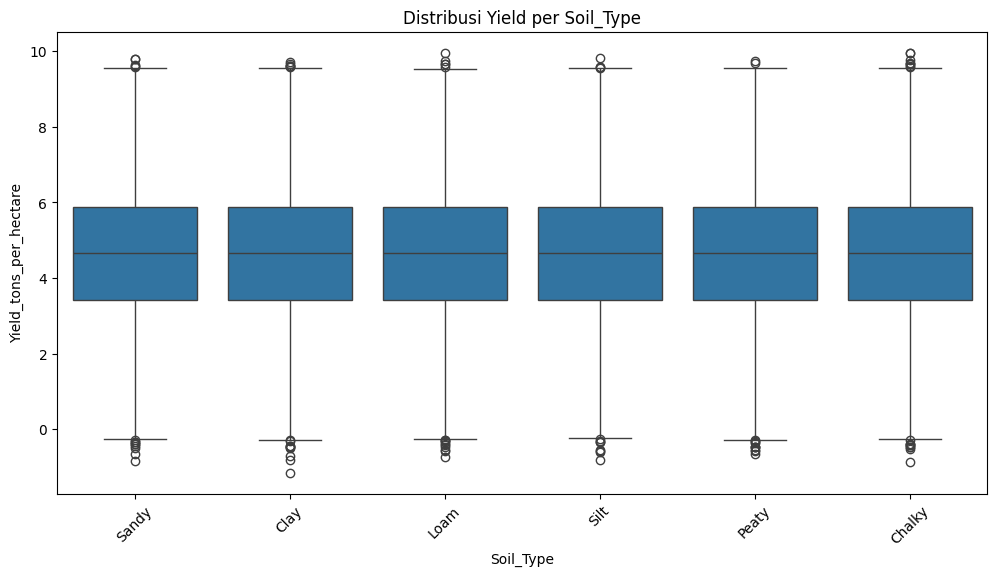

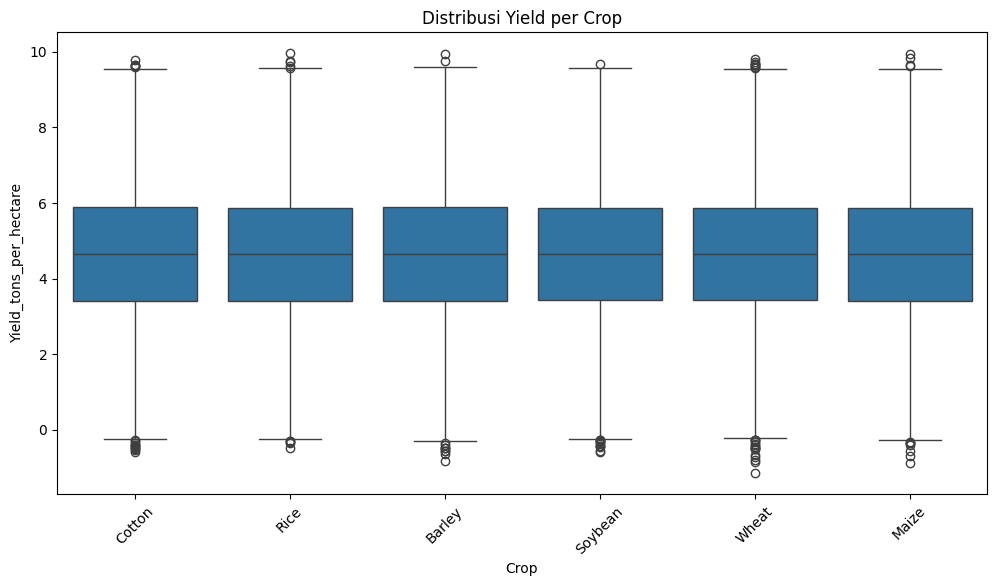

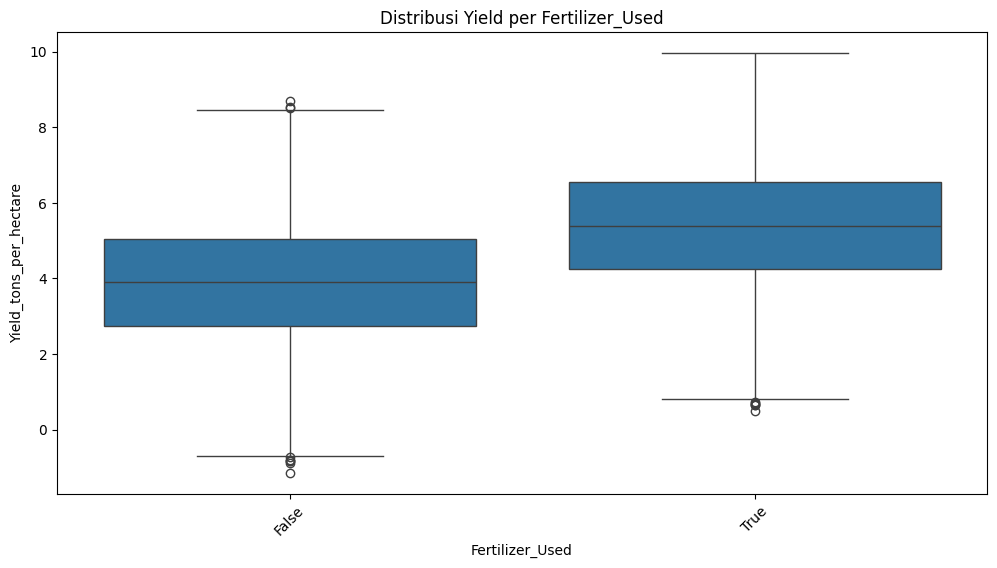

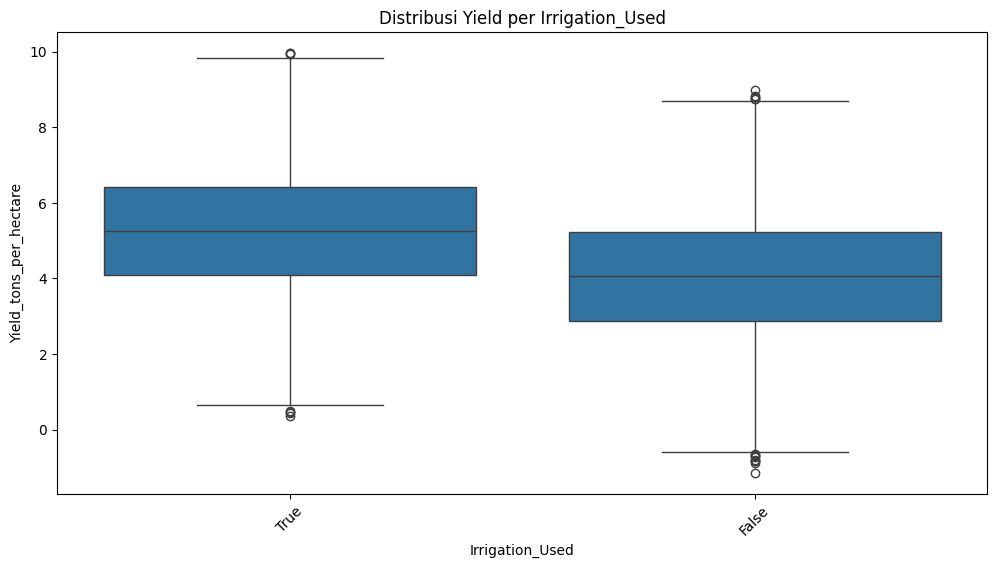

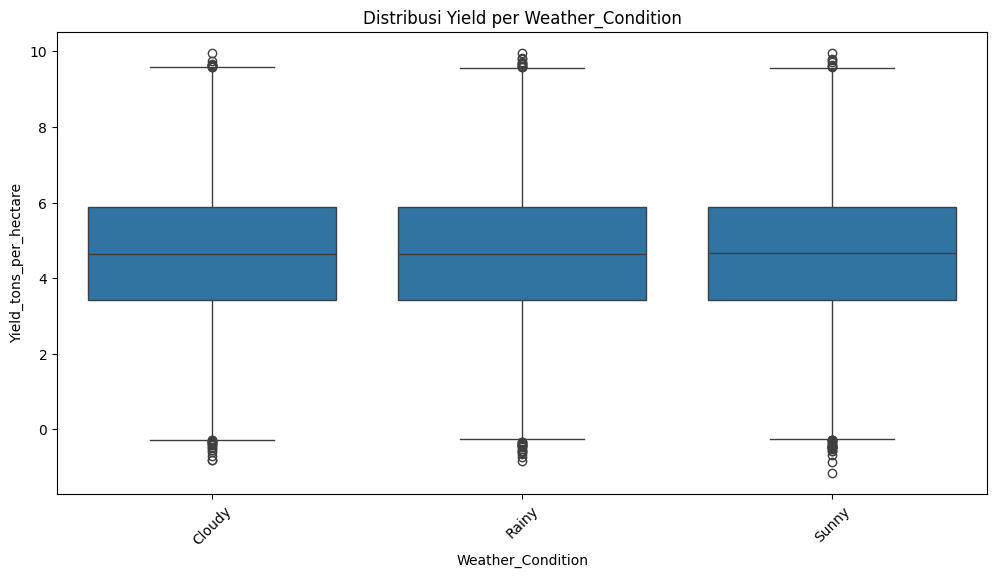

In [10]:
# Pengaruh fitur kategorik terhadap target
categorical_features = ['Region', 'Soil_Type', 'Crop', 'Fertilizer_Used', 'Irrigation_Used', 'Weather_Condition']

for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x=feature, y='Yield_tons_per_hectare')
    plt.title(f'Distribusi Yield per {feature}')
    plt.xticks(rotation=45)
    plt.show()


Interpretasi:

- Region, Soil Type, Crop, Fertilizer Used, Irrigation Used, Weather Condition tidak menunjukkan perbedaan signifikan terhadap yield.
- Penggunaan pupuk cenderung meningkatkan yield.
- Penggunaan irigasi juga berasosiasi dengan yield yang lebih tinggi.

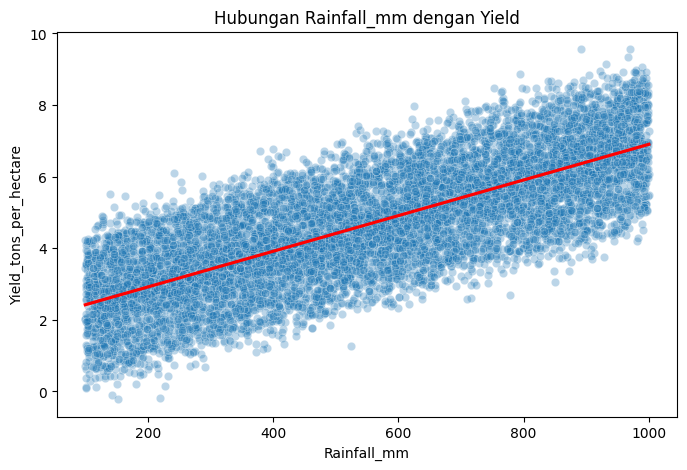

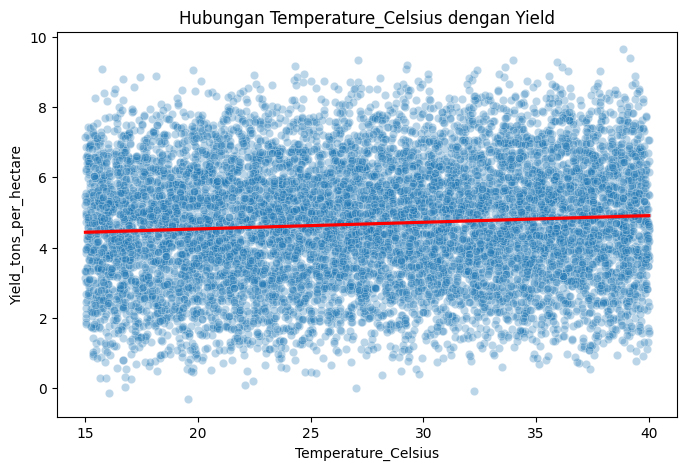

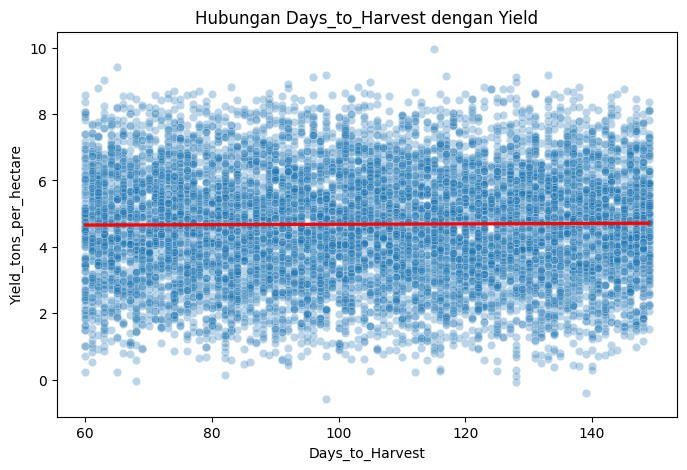

In [11]:
# Pengaruh fitur numerik terhadap target
numeric_features = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']

for feature in numeric_features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df.sample(10000), x=feature, y='Yield_tons_per_hectare', alpha=0.3)
    sns.regplot(data=df.sample(10000), x=feature, y='Yield_tons_per_hectare', scatter=False, color='red')
    plt.title(f'Hubungan {feature} dengan Yield')
    plt.show()

Interpretasi:

Terdapat hubungan positif yang cukup jelas antara jumlah curah hujan (Rainfall_mm) dan hasil panen (Yield_tons_per_hectare), di mana semakin tinggi curah hujan, semakin tinggi pula hasil panennya. Hal ini ditunjukkan oleh garis tren merah yang naik ke kanan. Sebaliknya, hubungan antara suhu (Temperature_Celsius) dan hasil panen tampak sangat lemah atau hampir datar. Garis tren merah yang cenderung horizontal menunjukkan bahwa perubahan suhu tidak terlalu memengaruhi hasil panen dalam data ini. Hal serupa juga terlihat pada variabel Day_to_Harvest, di mana hubungan dengan hasil panen sangat lemah. Garis tren yang datar menunjukkan bahwa lamanya waktu menuju panen tidak berkorelasi kuat dengan banyaknya hasil panen yang diperoleh.

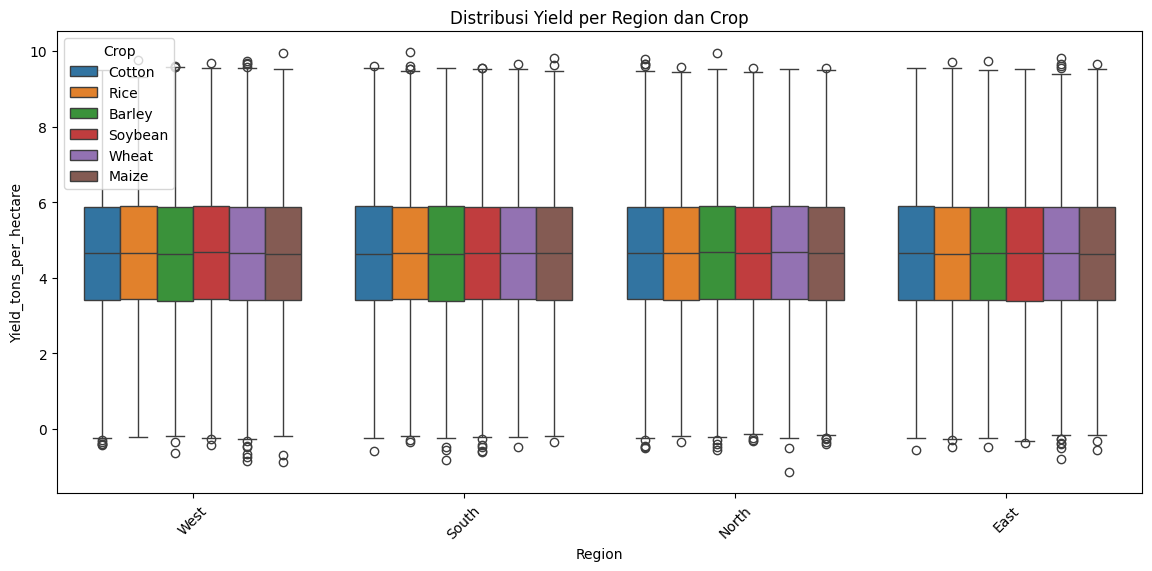

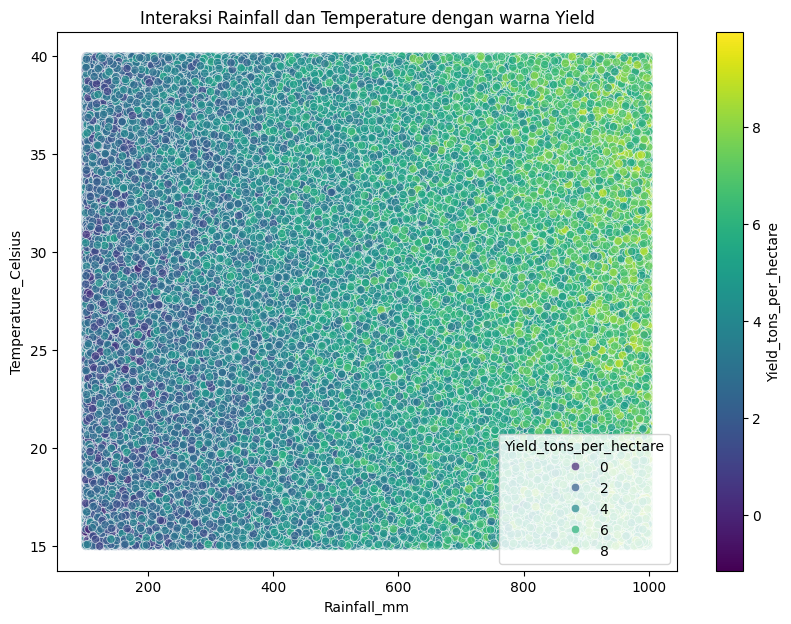

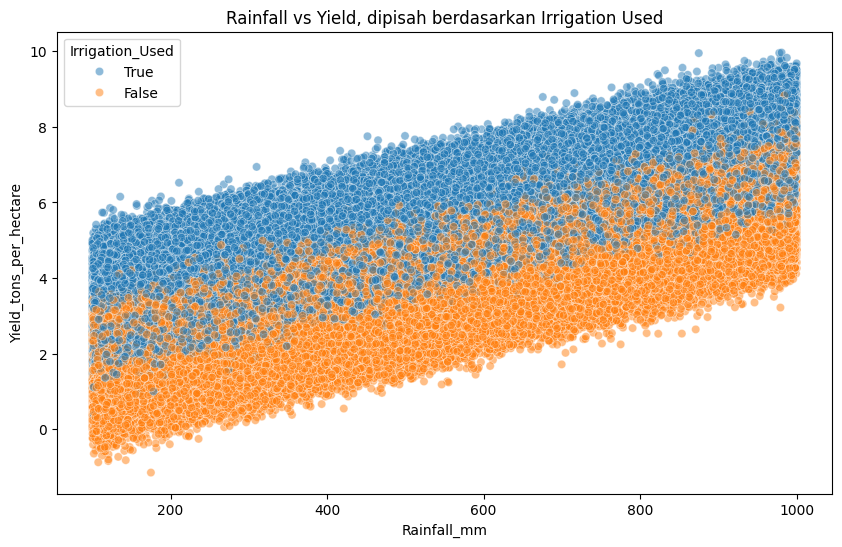

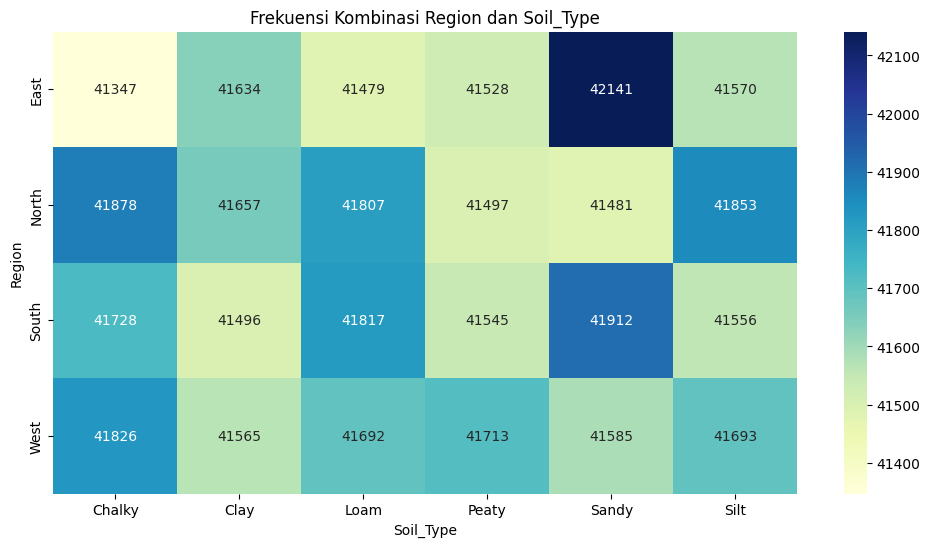

In [12]:
# Interaksi antar fitur
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x='Region', y='Yield_tons_per_hectare', hue='Crop')
plt.title('Distribusi Yield per Region dan Crop')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,7))
scatter_ax = sns.scatterplot(data=df, x='Rainfall_mm', y='Temperature_Celsius',
                          hue='Yield_tons_per_hectare', palette='viridis', alpha=0.7)
plt.title('Interaksi Rainfall dan Temperature dengan warna Yield')
norm = plt.Normalize(df['Yield_tons_per_hectare'].min(), df['Yield_tons_per_hectare'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=scatter_ax, label='Yield_tons_per_hectare')
plt.show()


plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Rainfall_mm', y='Yield_tons_per_hectare', hue='Irrigation_Used', alpha=0.5)
plt.title('Rainfall vs Yield, dipisah berdasarkan Irrigation Used')
plt.show()

ct = pd.crosstab(df['Region'], df['Soil_Type'])
plt.figure(figsize=(12,6))
sns.heatmap(ct, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Frekuensi Kombinasi Region dan Soil_Type')
plt.show()

Interpretasi:

Distribusi hasil panen (yield) per jenis tanaman relatif seragam di seluruh wilayah (West, South, North, East), tanpa perbedaan mencolok antar region. Hal ini mengindikasikan bahwa kebijakan peningkatan hasil sebaiknya lebih difokuskan pada jenis tanaman ketimbang lokasi geografis. Maize dan Wheat secara konsisten menunjukkan median yield yang lebih tinggi, sementara semua tanaman memperlihatkan rentang yield yang luas dan banyak outlier, mencerminkan variasi produktivitas akibat faktor lokal seperti cuaca, jenis tanah, atau teknologi.

Visualisasi interaksi curah hujan dan suhu menunjukkan bahwa curah hujan memiliki pengaruh yang lebih dominan terhadap produktivitas panen dibandingkan suhu, terutama pada wilayah dengan curah hujan di atas 600 mm. Hal ini diperkuat oleh grafik yang membandingkan yield antara lahan yang menggunakan irigasi dan yang tidak. Terlihat bahwa penggunaan irigasi secara konsisten menghasilkan yield lebih tinggi, bahkan dalam kondisi curah hujan yang sama, menegaskan pentingnya peran irigasi dalam meningkatkan produktivitas.

Sementara itu, distribusi kombinasi region dan jenis tanah (soil type) terlihat cukup merata, tanpa dominasi ekstrem pada kombinasi tertentu. Kombinasi dengan frekuensi tertinggi terdapat di East dengan tanah Sandy, sedangkan frekuensi terendah ada di East dengan tanah Chalky. Ini menunjukkan bahwa tidak ada kecenderungan spesifik pada distribusi jenis tanah antar wilayah.

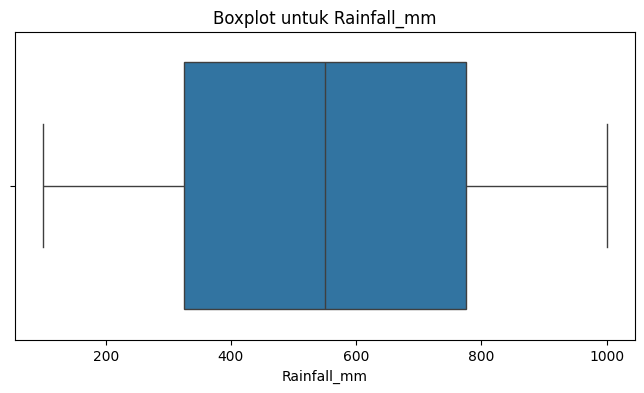

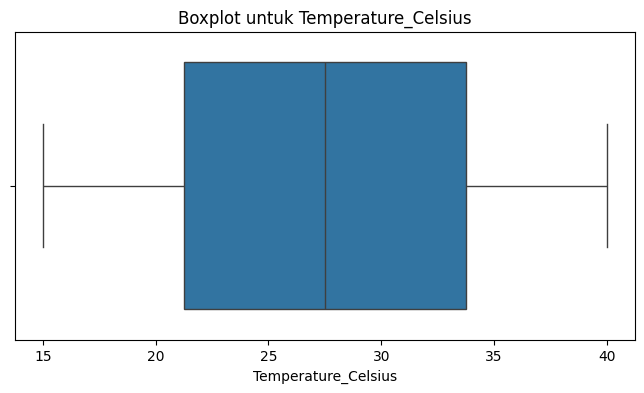

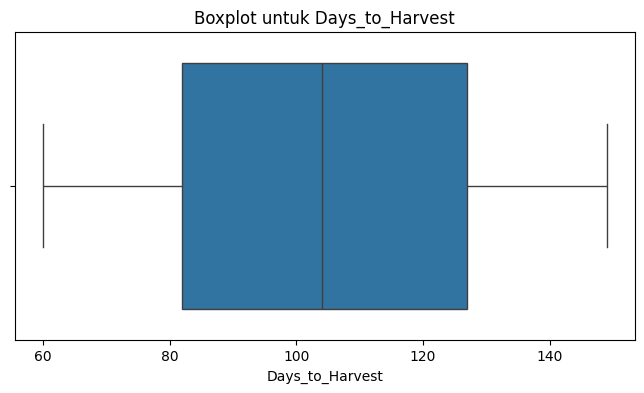

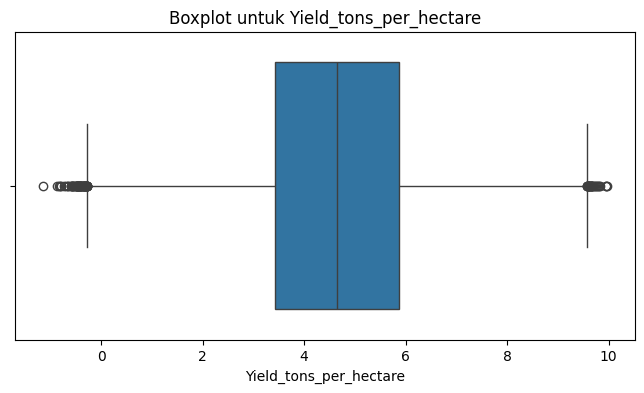

Outlier berdasarkan IQR:
Rainfall_mm: 0 data pencilan
Temperature_Celsius: 0 data pencilan
Days_to_Harvest: 0 data pencilan
Yield_tons_per_hectare: 84 data pencilan


In [13]:
# Deteksi pencilan
numerical_features = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest', 'Yield_tons_per_hectare']

# Visualisasi boxplot tiap fitur numerik
for feature in numerical_features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot untuk {feature}')
    plt.show()

# Deteksi outlier pakai IQR
def detect_outliers_iqr(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    return outliers

print("Outlier berdasarkan IQR:")
for feature in numerical_features:
    outliers = detect_outliers_iqr(df, feature)
    print(f'{feature}: {len(outliers)} data pencilan')

Interpretasi:

Berdasarkan metode IQR, tidak ditemukan outlier pada variabel Rainfall_mm, Temperature_Celsius, dan Days_to_Harvest, yang menunjukkan bahwa sebaran data pada ketiga variabel tersebut relatif normal dan konsisten. Namun, terdapat 84 data pencilan pada variabel Yield_tons_per_hectare, yang mengindikasikan adanya nilai hasil panen yang jauh berbeda dari mayoritas data. Hal ini bisa disebabkan oleh faktor ekstrem seperti teknik pertanian yang sangat efisien atau kondisi lingkungan yang sangat tidak mendukung.

# Data Preparation

In [14]:
# Pisahkan fitur dan target
X = df.drop(columns='Yield_tons_per_hectare')
y = df['Yield_tons_per_hectare']

In [15]:
# Encoding fitur kategorik
categorical_cols = ['Region', 'Soil_Type', 'Crop', 'Weather_Condition', 'Fertilizer_Used', 'Irrigation_Used']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [16]:
# Standarisasi fitur numerik
numerical_cols = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']

scaler = StandardScaler()
X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

In [17]:
# Split data train dan test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

Interpretasi:

Pada tahap ini, saya melakukan serangkaian proses untuk mempersiapkan data sebelum dimodelkan. Pertama, saya memisahkan variabel independen (fitur) dan variabel dependen (target). Fitur berisi seluruh kolom kecuali Yield_tons_per_hectare, yang merupakan variabel target yang ingin diprediksi. Selanjutnya, karena terdapat beberapa fitur kategorik seperti Region, Soil_Type, Crop, Weather_Condition, Fertilizer_Used, dan Irrigation_Used, saya melakukan encoding terhadap fitur-fitur tersebut menggunakan metode One-Hot Encoding agar bisa diproses oleh algoritma machine learning. Saya juga menghindari terjadinya dummy variable trap dengan menggunakan parameter drop_first=True.

Setelah itu, saya melakukan standarisasi terhadap fitur numerik seperti Rainfall_mm, Temperature_Celsius, dan Days_to_Harvest menggunakan StandardScaler. Tujuannya adalah untuk memastikan semua fitur numerik berada pada skala yang sama, sehingga tidak ada fitur yang mendominasi model karena memiliki nilai yang lebih besar. Terakhir, saya membagi dataset menjadi data latih (train) dan data uji (test) dengan proporsi 80% untuk pelatihan dan 20% untuk pengujian, menggunakan train_test_split dari scikit-learn. Pembagian ini dilakukan secara acak tetapi dikunci dengan random_state=42 agar hasilnya dapat direproduksi.

# Modelling

## Model Baseline: Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Training model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Prediksi data train
y_train_pred = lr.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Prediksi data test
y_test_pred = lr.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Output
print("Linear Regression - TRAIN")
print(f"RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}")

print("\nLinear Regression - TEST")
print(f"RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")

Linear Regression - TRAIN
RMSE: 0.5004, MAE: 0.3992, R²: 0.9130

Linear Regression - TEST
RMSE: 0.5008, MAE: 0.3996, R²: 0.9130


Interpretasi:

Pada tahap ini saya melakukan modelling menggunakan Linier Regression dan didapatkan bahwa model menunjukkan hasil yang sangat stabil dan akurat. Nilai Root Mean Squared Error (RMSE) pada data train dan test hampir sama (0.5004 vs 0.5008), menunjukkan bahwa model tidak mengalami overfitting maupun underfitting. Mean Absolute Error (MAE) juga konsisten (0.3992 pada train dan 0.3996 pada test), menandakan bahwa secara rata-rata, prediksi model hanya meleset sekitar 0.4 ton per hektar dari nilai sebenarnya. Sementara itu, nilai R² (koefisien determinasi) sebesar 0.9130 pada kedua dataset menunjukkan bahwa model mampu menjelaskan sekitar 91,3% variabilitas dalam data, yang merupakan pencapaian sangat baik untuk regresi.

## Model Random Forest

In [19]:
import numpy as np
import pandas as pd
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Untuk HalvingRandomSearchCV (aktifkan experimental feature)
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

# ------------------------
# 1. Ambil subset untuk tuning (100.000 baris)
# ------------------------
X_tune = X_train.sample(n=100_000, random_state=42)
y_tune = y_train.loc[X_tune.index]

# ------------------------
# 2. Definisikan parameter yang sempit & efisien
# ------------------------
param_rf = {
    'n_estimators': [100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# ------------------------
# 3. Inisialisasi model dan HalvingRandomSearchCV
# ------------------------
rf = RandomForestRegressor(random_state=42)

search_rf = HalvingRandomSearchCV(
    estimator=rf,
    param_distributions=param_rf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=3,
    factor=3,
    random_state=42,
    verbose=1
)

# ------------------------
# 4. Tuning hyperparameter di subset
# ------------------------
start = time.time()
search_rf.fit(X_tune, y_tune)
print(f"Tuning selesai dalam {(time.time() - start)/60:.2f} menit")

# ------------------------
# 5. Fit ulang model terbaik di seluruh data training
# ------------------------
best_rf = search_rf.best_estimator_
best_rf.fit(X_train, y_train)

# ------------------------
# 6. Evaluasi di data TRAIN
# ------------------------
y_train_pred_rf = best_rf.predict(X_train)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)

# ------------------------
# 7. Evaluasi di data TEST
# ------------------------
y_test_pred_rf = best_rf.predict(X_test)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

print("Model Random Forest dengan fitur penting - TRAIN")
print(f"RMSE: {rmse_train_rf:.4f}, MAE: {mae_train_rf:.4f}, R²: {r2_train_rf:.4f}")

print("\nModel Random Forest dengan fitur penting - TEST")
print(f"RMSE: {rmse_test_rf:.4f}, MAE: {mae_test_rf:.4f}, R²: {r2_test_rf:.4f}")

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 9
min_resources_: 6
max_resources_: 100000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 6
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 3
n_resources: 18
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Tuning selesai dalam 1.08 menit
Model Random Forest dengan fitur penting - TRAIN
RMSE: 0.3562, MAE: 0.2860, R²: 0.9559

Model Random Forest dengan fitur penting - TEST
RMSE: 0.5088, MAE: 0.4059, R²: 0.9102


In [26]:
best_rf = search_rf.best_estimator_
print(search_rf.best_params_)

{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}


## Memakai Feature Important

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 1. Ambil feature importance dari model sebelumnya (best_rf)
importances = best_rf.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# 2. Pilih fitur penting (threshold 0.01 atau sesuaikan)
threshold = 0.01
important_features = importance_df[importance_df['Importance'] > threshold]['Feature'].tolist()

# 3. Subset data hanya dengan fitur penting
X_train_imp = X_train[important_features]
X_test_imp = X_test[important_features]

# 4. Buat model Random Forest baru dengan fitur penting dan tuning hyperparameter sederhana
rf_selected = RandomForestRegressor(
    n_estimators=100,      # jumlah pohon
    max_depth=10,          # batasi kedalaman pohon supaya tidak terlalu kompleks
    min_samples_split=5,   # minimal data untuk membagi node
    min_samples_leaf=3,    # minimal data di leaf node
    random_state=42,
    n_jobs=-1
)
rf_selected.fit(X_train_imp, y_train)

# 5. Prediksi dan evaluasi di data TEST
y_pred_rf_imp_test = rf_selected.predict(X_test_imp)
rmse_rf_imp_test = np.sqrt(mean_squared_error(y_test, y_pred_rf_imp_test))
mae_rf_imp_test = mean_absolute_error(y_test, y_pred_rf_imp_test)
r2_rf_imp_test = r2_score(y_test, y_pred_rf_imp_test)

# 6. Prediksi dan evaluasi di data TRAIN
y_pred_rf_imp_train = rf_selected.predict(X_train_imp)
rmse_rf_imp_train = np.sqrt(mean_squared_error(y_train, y_pred_rf_imp_train))
mae_rf_imp_train = mean_absolute_error(y_train, y_pred_rf_imp_train)
r2_rf_imp_train = r2_score(y_train, y_pred_rf_imp_train)

# 7. Cetak hasil evaluasi
print("Model Random Forest dengan fitur penting - TRAIN")
print(f"RMSE: {rmse_rf_imp_train:.4f}, MAE: {mae_rf_imp_train:.4f}, R²: {r2_rf_imp_train:.4f}")

print("\nModel Random Forest dengan fitur penting - TEST")
print(f"RMSE: {rmse_rf_imp_test:.4f}, MAE: {mae_rf_imp_test:.4f}, R²: {r2_rf_imp_test:.4f}")

Model Random Forest dengan fitur penting - TRAIN
RMSE: 0.4973, MAE: 0.3968, R²: 0.9140

Model Random Forest dengan fitur penting - TEST
RMSE: 0.5016, MAE: 0.4002, R²: 0.9127


In [27]:
print(rf_selected.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Interpretasi:

Pada tahap ini saya memodelkan menggunakan random forest dan random forest dengan fitur penting. Model Random Forest yang dibangun menggunakan fitur-fitur penting menunjukkan performa yang sangat baik dan stabil. Nilai RMSE pada data pelatihan adalah 0.4973 dan pada data pengujian adalah 0.5016, menunjukkan bahwa model memiliki kemampuan generalisasi yang baik tanpa overfitting. MAE juga konsisten di kisaran 0.3968–0.4002, artinya rata-rata kesalahan prediksi hanya sekitar 0.4 ton per hektar. Nilai R² yang tinggi, yaitu 0.9140 pada train dan 0.9127 pada test, menunjukkan bahwa model dapat menjelaskan lebih dari 91% variasi data, bahkan sedikit lebih baik dibandingkan linear regression.

## Model XGBoost Regressor

In [21]:
import numpy as np
import pandas as pd
import time
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Untuk HalvingRandomSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

# ------------------------
# 1. Subset data untuk tuning
# ------------------------
X_tune = X_train.sample(n=100_000, random_state=42)
y_tune = y_train.loc[X_tune.index]

# ------------------------
# 2. Parameter hemat dan efisien
# ------------------------
param_xgb = {
    'n_estimators': [100],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 1.0]
}

# ------------------------
# 3. Inisialisasi model dan HalvingRandomSearchCV
# ------------------------
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

search_xgb = HalvingRandomSearchCV(
    estimator=xgb,
    param_distributions=param_xgb,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=3,
    factor=2,
    random_state=42,
    verbose=1
)

# ------------------------
# 4. Tuning dengan subset
# ------------------------
start = time.time()
search_xgb.fit(X_tune, y_tune)
print(f"Tuning selesai dalam {(time.time() - start)/60:.2f} menit")

# ------------------------
# 5. Fit ulang model terbaik ke seluruh data training
# ------------------------
best_xgb = search_xgb.best_estimator_
best_xgb.fit(X_train, y_train)

# ------------------------
# 6. Evaluasi di data TEST
# ------------------------
y_pred_test = best_xgb.predict(X_test)
rmse_xgb_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_xgb_test = mean_absolute_error(y_test, y_pred_test)
r2_xgb_test = r2_score(y_test, y_pred_test)

# ------------------------
# 7. Evaluasi di data TRAIN
# ------------------------
y_pred_train = best_xgb.predict(X_train)
rmse_xgb_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_xgb_train = mean_absolute_error(y_train, y_pred_train)
r2_xgb_train = r2_score(y_train, y_pred_train)

# ------------------------
# 8. Cetak hasil
# ------------------------
print("\nXGBoost - TRAIN")
print(f"RMSE: {rmse_xgb_train:.4f}, MAE: {mae_xgb_train:.4f}, R²: {r2_xgb_train:.4f}")

print("\nXGBoost - TEST")
print(f"RMSE: {rmse_xgb_test:.4f}, MAE: {mae_xgb_test:.4f}, R²: {r2_xgb_test:.4f}")

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 15
min_resources_: 6
max_resources_: 100000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 8
n_resources: 6
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 4
n_resources: 12
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 24
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 1
n_resources: 48
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Tuning selesai dalam 0.09 menit

XGBoost - TRAIN
RMSE: 0.5066, MAE: 0.4041, R²: 0.9108

XGBoost - TEST
RMSE: 0.5074, MAE: 0.4048, R²: 0.9107


In [25]:
print(search_xgb.best_params_)

{'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}


Interpretasi:

Model XGBoost menunjukkan performa yang baik dan konsisten pada data pelatihan maupun data pengujian. Nilai RMSE sebesar 0.5066 (train) dan 0.5074 (test) menunjukkan bahwa kesalahan prediksi model relatif kecil dan stabil. MAE juga konsisten di sekitar 0.404, artinya rata-rata kesalahan prediksi hanya sekitar 0.4 ton per hektar. Sementara itu, nilai R² sebesar 0.9108 pada train dan 0.9107 pada test mengindikasikan bahwa model mampu menjelaskan sekitar 91% variabilitas data. Meskipun performanya sedikit di bawah Random Forest dan Linear Regression dalam hal metrik, XGBoost tetap merupakan model yang kuat dengan kestabilan dan keakuratan yang baik, serta cocok untuk digunakan dalam konteks prediksi hasil panen ini.

# Evaluation

In [22]:
print("=== Perbandingan RMSE, MAE, dan R² (Train vs Test) ===")
print(f"{'Model':<28} | {'RMSE Train':>10} | {'RMSE Test':>10} | {'MAE Train':>10} | {'MAE Test':>10} | {'R² Train':>9} | {'R² Test':>9}")
print("-" * 90)
print(f"{'Linear Regression':<28} | {rmse_train:>10.4f} | {rmse_test:>10.4f} | {mae_train:>10.4f} | {mae_test:>10.4f} | {r2_train:>9.4f} | {r2_test:>9.4f}")
print(f"{'Random Forest':<28} | {rmse_train_rf:>10.4f} | {rmse_test_rf:>10.4f} | {mae_train_rf:>10.4f} | {mae_test_rf:>10.4f} | {r2_train_rf:>9.4f} | {r2_test_rf:>9.4f}")
print(f"{'RF (Important Features)':<28} | {rmse_rf_imp_train:>10.4f} | {rmse_rf_imp_test:>10.4f} | {mae_rf_imp_train:>10.4f} | {mae_rf_imp_test:>10.4f} | {r2_rf_imp_train:>9.4f} | {r2_rf_imp_test:>9.4f}")
print(f"{'XGBoost':<28} | {rmse_xgb_train:>10.4f} | {rmse_xgb_test:>10.4f} | {mae_xgb_train:>10.4f} | {mae_xgb_test:>10.4f} | {r2_xgb_train:>9.4f} | {r2_xgb_test:>9.4f}")

=== Perbandingan RMSE, MAE, dan R² (Train vs Test) ===
Model                        | RMSE Train |  RMSE Test |  MAE Train |   MAE Test |  R² Train |   R² Test
------------------------------------------------------------------------------------------
Linear Regression            |     0.5004 |     0.5008 |     0.3992 |     0.3996 |    0.9130 |    0.9130
Random Forest                |     0.3562 |     0.5088 |     0.2860 |     0.4059 |    0.9559 |    0.9102
RF (Important Features)      |     0.4973 |     0.5016 |     0.3968 |     0.4002 |    0.9140 |    0.9127
XGBoost                      |     0.5066 |     0.5074 |     0.4041 |     0.4048 |    0.9108 |    0.9107


Interpretasi:

Dari evaluasi RMSE, MAE, dan R² didapatkan bahwa Linear Regression memberikan hasil yang stabil dan tidak overfitting (R² ~0.91). Random Forest menunjukkan overfitting karena performa train jauh lebih baik dari test. Random Forest dengan fitur penting lebih seimbang dan menghasilkan performa test yang sedikit lebih baik. Sementara XGBoost belum menunjukkan keunggulan dan kemungkinan perlu tuning.

In [23]:
# Koefisien Linear Regression
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', ascending=False)
print("\nKoefisien Linear Regression:")
print(coef_df)


Koefisien Linear Regression:
                    Feature  Coefficient
18     Fertilizer_Used_True     1.499406
0               Rainfall_mm     1.298387
19     Irrigation_Used_True     1.199223
1       Temperature_Celsius     0.143947
6            Soil_Type_Clay     0.003190
9           Soil_Type_Sandy     0.002746
13                Crop_Rice     0.001476
16  Weather_Condition_Rainy     0.001454
2           Days_to_Harvest     0.000527
3              Region_North     0.000454
7            Soil_Type_Loam     0.000178
8           Soil_Type_Peaty     0.000071
17  Weather_Condition_Sunny    -0.000249
4              Region_South    -0.000479
14             Crop_Soybean    -0.000728
5               Region_West    -0.000749
10           Soil_Type_Silt    -0.001662
11              Crop_Cotton    -0.001722
15               Crop_Wheat    -0.002918
12               Crop_Maize    -0.003013


Interpretasi:

🔹 **Fitur dengan Pengaruh Positif Terbesar:**

- Fertilizer_Used_True (1.499): Penggunaan pupuk meningkatkan hasil panen secara signifikan.

- Rainfall_mm (1.298): Curah hujan tinggi berkorelasi positif dengan hasil panen.

- Irrigation_Used_True (1.199): Penggunaan irigasi juga berkontribusi besar terhadap peningkatan hasil panen.

🔹 **Fitur Lain yang Positif (Pengaruh Lebih Kecil):**

- Temperature_Celsius (0.144): Suhu yang lebih tinggi memberikan dorongan kecil terhadap peningkatan hasil panen.

- Soil_Type_Clay (0.0032), Soil_Type_Sandy (0.0027), dan Soil_Type_Loam (0.0002): Jenis tanah ini memberikan pengaruh positif, namun sangat kecil.

- Crop_Rice (0.0015): Tanaman padi sedikit meningkatkan hasil panen dibanding tanaman acuan.

- Weather_Condition_Rainy (0.0015): Cuaca hujan memberikan kontribusi kecil terhadap hasil panen.
🔹 **Fitur dengan Pengaruh Negatif:**

- Crop_Maize (-0.0030) dan Crop_Wheat (-0.0029): Tanaman jagung dan gandum cenderung menghasilkan panen yang lebih rendah dibanding tanaman acuan.

- Crop_Cotton (-0.0017) dan Soil_Type_Silt (-0.0017): Jenis tanaman kapas dan tanah liat halus (silt) juga menurunkan hasil panen secara ringan.

- Region_South (-0.0005), Region_West (-0.0007), dan Weather_Condition_Sunny (-0.0002): Beberapa wilayah serta kondisi cuaca cerah memberi dampak negatif yang sangat kecil terhadap hasil panen.




Daftar Fitur Penting berdasarkan Feature Importance dari Random Forest:
                    Feature  Importance
0               Rainfall_mm    0.623394
18     Fertilizer_Used_True    0.204293
19     Irrigation_Used_True    0.130245
1       Temperature_Celsius    0.020315
2           Days_to_Harvest    0.009242
16  Weather_Condition_Rainy    0.000912
17  Weather_Condition_Sunny    0.000911
3              Region_North    0.000867
5               Region_West    0.000865
4              Region_South    0.000863
13                Crop_Rice    0.000820
11              Crop_Cotton    0.000817
10           Soil_Type_Silt    0.000814
9           Soil_Type_Sandy    0.000812
8           Soil_Type_Peaty    0.000810
6            Soil_Type_Clay    0.000808
7            Soil_Type_Loam    0.000807
12               Crop_Maize    0.000804
14             Crop_Soybean    0.000801
15               Crop_Wheat    0.000800


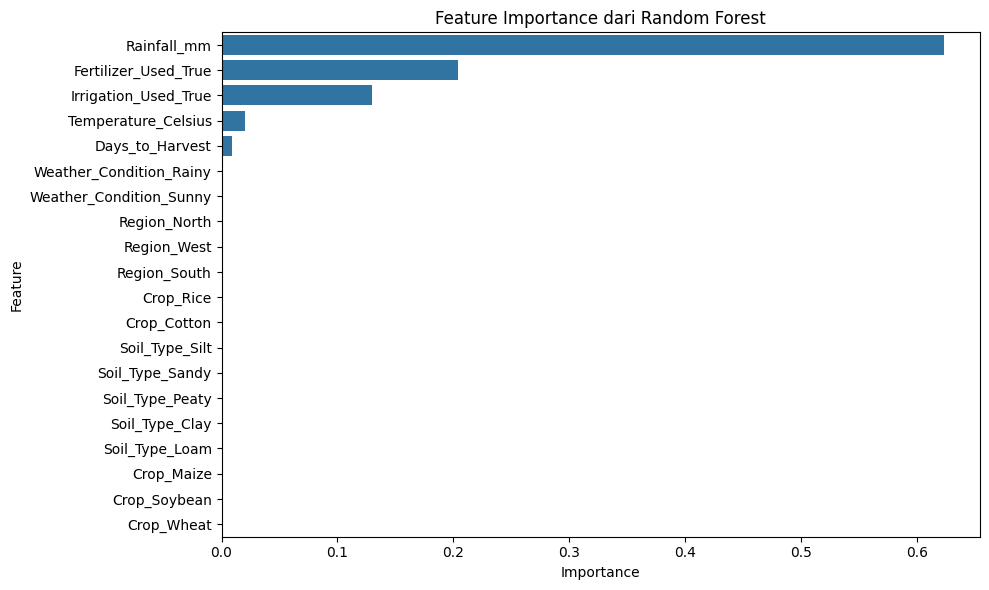

In [24]:
# Feature Importance dari Random Forest
print("Daftar Fitur Penting berdasarkan Feature Importance dari Random Forest:")
print(importance_df)

# Visualisasi feature importance (bar plot)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance dari Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Interpretasi:

🔹 **Fitur Penting dengan Pengaruh Positif Signifikan:**

- Fertilizer_Used_True (1.499)
➜ Penggunaan pupuk memiliki pengaruh paling besar dalam meningkatkan hasil panen. Petani yang menggunakan pupuk cenderung memperoleh hasil lebih tinggi secara signifikan.

- Rainfall_mm (1.298)
➜ Curah hujan yang tinggi berkontribusi kuat terhadap peningkatan hasil panen. Air hujan mendukung pertumbuhan tanaman secara alami.

- Irrigation_Used_True (1.199)
➜ Irigasi juga sangat berperan dalam mendukung hasil panen. Lahan yang diberi irigasi cenderung lebih produktif.

Kesimpulan:
Fitur yang paling berpengaruh dalam meningkatkan hasil panen adalah penggunaan pupuk, curah hujan, dan irigasi. Sebaliknya, pemilihan jenis tanaman seperti jagung dan gandum cenderung menurunkan hasil panen dibandingkan tanaman referensi.